In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jruvika/fake-news-detection

Dataset URL: https://www.kaggle.com/datasets/jruvika/fake-news-detection
License(s): ODbL-1.0
fake-news-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fake-news-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('/content/data.csv')
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [7]:
df.shape

(4009, 4)

In [8]:
df.isnull().sum()

URLs         0
Headline     0
Body        21
Label        0
dtype: int64

<Axes: >

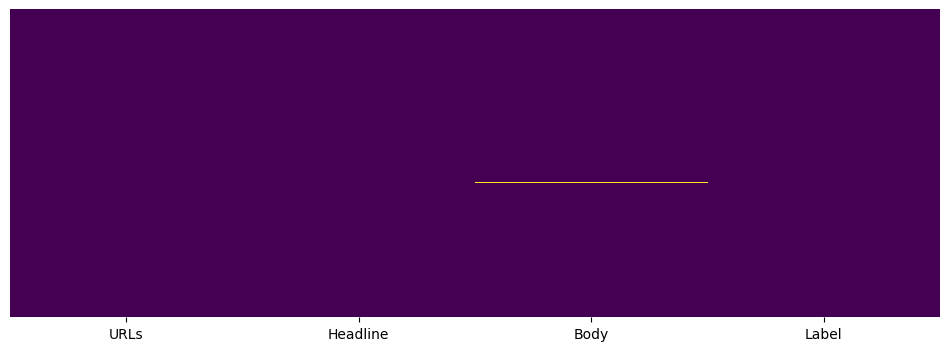

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,4)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(3988, 4)

In [13]:
df.isnull().sum()

URLs        0
Headline    0
Body        0
Label       0
dtype: int64

In [14]:
df = df.reset_index(drop=True)
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [15]:
df.drop(['URLs'], axis=1, inplace=True)

In [16]:
df.rename(columns={'Headline': 'title', 'Body': 'text', 'Label': 'label'}, inplace=True)

In [17]:
df.head()

,title,text,label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [18]:
count = df.label.value_counts()
count

label
0    2120
1    1868
Name: count, dtype: int64

In [19]:
x=df.drop('label', axis=1)
y=df['label']

In [20]:
x.shape, y.shape

((3988, 2), (3988,))

In [21]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [22]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

In [23]:
### Vocabulary size
voc_size=2000

In [24]:
messages=x.copy()
messages.head()

,title,text
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed..."
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin..."


In [25]:
messages['title'][0]

'Four ways Bob Corker skewered Donald Trump'

In [26]:
import nltk
import re
from nltk.corpus import stopwords

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [29]:
len(corpus)

3988

In [30]:
corpus

['four way bob corker skewer donald trump',
 'linklat war veteran comedi speak modern america say star',
 'trump fight corker jeopard legisl agenda',
 'egypt cheiron win tie pemex mexican onshor oil field',
 'jason aldean open snl vega tribut',
 'jetnat fanduel leagu week',
 'kansa tri tax plan similar trump fail',
 'india rbi chief growth import cost inflat newspap',
 'epa chief sign rule clean power plan exit tuesday',
 'talk sale air berlin plane easyjet risk collaps report',
 'u presid donald trump quietli sign law allow warrantless search part va dc md',
 'fantasi footbal team defens rank week',
 'shut play damn basebal',
 'deloitt cyber attack affect client guardian',
 'chuck axe hbd brickyard adam moonlight ace chuck season final',
 'gunman girlfriend said know plan harm',
 'maril danley gunman girlfriend say unawar plan',
 'trump immigr rhetor echo bitter fight',
 'trump bemoan littl appreci san juan mayor beg water',
 'meet militari trump talk calm storm',
 'teacher spark outr

In [31]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]
onehot_repr

[[890, 489, 1050, 89, 1269, 150, 491],
 [110, 1915, 974, 13, 1656, 1648, 1615, 816, 34],
 [491, 1895, 89, 1482, 1840, 1796],
 [979, 1137, 1551, 1170, 818, 502, 598, 372, 912],
 [1805, 654, 1187, 339, 1147, 236],
 [1934, 600, 1744, 255],
 [1321, 34, 1506, 1307, 550, 491, 1650],
 [1624, 198, 1342, 1102, 352, 1984, 1213, 1542],
 [1772, 1342, 1070, 1263, 206, 1820, 1307, 941, 853],
 [1070, 1028, 1839, 300, 769, 150, 725, 278, 1526],
 [1216, 1880, 150, 491, 183, 1070, 1839, 23, 1478, 54, 1862, 1164, 179, 27],
 [884, 986, 1869, 1115, 495, 255],
 [816, 1990, 1629, 210],
 [1503, 1225, 276, 574, 1879, 1273],
 [327, 989, 610, 997, 595, 1779, 1112, 327, 212, 931],
 [1763, 698, 962, 325, 1307, 80],
 [198, 1709, 1763, 698, 816, 1718, 1307],
 [491, 122, 973, 1957, 780, 1895],
 [491, 61, 1744, 465, 1113, 319, 1539, 1821, 1398],
 [1233, 153, 491, 1070, 1366, 1086],
 [1880, 608, 1649, 1177, 638, 666, 1145, 1662],
 [660, 610, 1331, 119, 1475, 1065, 26, 1475, 1153, 845, 1582, 275, 832, 1416],
 [237, 1761

In [32]:
corpus[0]

'four way bob corker skewer donald trump'

In [33]:
onehot_repr[0]

[890, 489, 1050, 89, 1269, 150, 491]

In [34]:
max_length=0
for i in range(len(corpus)):
    sent_length = len(corpus[i])
    if sent_length > max_length:
        max_length = sent_length

print(max_length)

392


In [35]:
sent_length=400
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[ 890  489 1050 ...    0    0    0]
 [ 110 1915  974 ...    0    0    0]
 [ 491 1895   89 ...    0    0    0]
 ...
 [ 491 1704  160 ...    0    0    0]
 [1867  637 1997 ...    0    0    0]
 [1596 1880 1805 ...    0    0    0]]


In [36]:
embedded_docs[0]

array([ 890,  489, 1050,   89, 1269,  150,  491,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [74]:
## Creating model
from keras.layers import Dropout, Bidirectional, GRU
embedding_vector_features=100 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(GRU(100, return_sequences=False))  # Using GRU instead of LSTM
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 400, 100)          200000    
                                                                 
 bidirectional_11 (Bidirect  (None, 400, 200)          160800    
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 400, 200)          0         
                                                                 
 gru_8 (GRU)                 (None, 100)               90600     
                                                                 
 dropout_22 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                     

In [75]:
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping

# # Define parameters
# vocab_size = 2000
# embedding_dim = 100
# input_length = 100
# lstm_units = 100
# gru_units = 100

# # Define the model
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
# model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(GRU(gru_units, return_sequences=False))  # Using GRU instead of LSTM
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
len(embedded_docs),y.shape

(3988, (3988,))

In [60]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [61]:
X_final.shape,y_final.shape

((3988, 400), (3988,))

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [76]:
### Finally Training
# history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
84/84 [==============================] - 136s 2s/step - loss: 0.6932 - accuracy: 0.5197 - val_loss: 0.6925 - val_accuracy: 0.5513
Epoch 2/20
84/84 [==============================] - 133s 2s/step - loss: 0.6930 - accuracy: 0.5234 - val_loss: 0.6887 - val_accuracy: 0.5513
Epoch 3/20
84/84 [==============================] - 132s 2s/step - loss: 0.6921 - accuracy: 0.5283 - val_loss: 0.6963 - val_accuracy: 0.4487
Epoch 4/20
84/84 [==============================] - 134s 2s/step - loss: 0.6937 - accuracy: 0.5155 - val_loss: 0.6898 - val_accuracy: 0.5513
Epoch 5/20
84/84 [==============================] - 130s 2s/step - loss: 0.6928 - accuracy: 0.5193 - val_loss: 0.6909 - val_accuracy: 0.5513


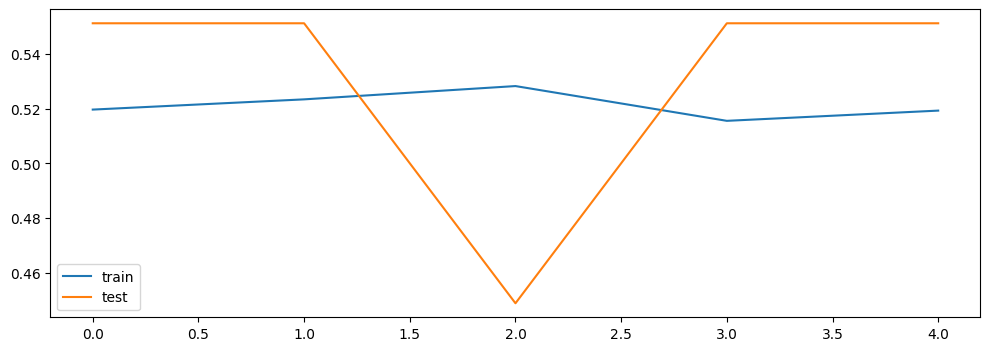

In [77]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

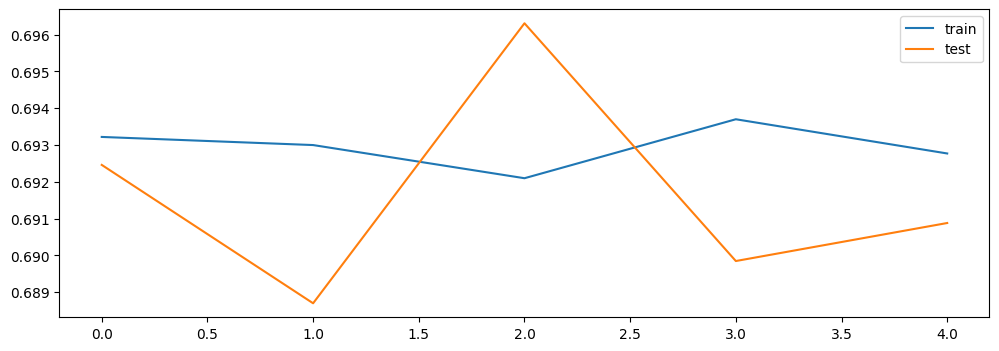

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [80]:
y_pred=model.predict(X_test)

42/42 [==============================] - 5s 103ms/step


In [81]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

In [82]:
from sklearn.metrics import confusion_matrix

In [83]:
confusion_matrix(y_test,y_pred)

array([[726,   0],
       [591,   0]])

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.55125284738041

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       726
           1       0.00      0.00      0.00       591

    accuracy                           0.55      1317
   macro avg       0.28      0.50      0.36      1317
weighted avg       0.30      0.55      0.39      1317



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
